In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load the data
df_0 = pd.read_csv(r"C:\Users\pingk\Downloads\fadhli nitip\asik_rt4_now with indo new.csv")

In [3]:
# Define the target variable and numeric columns
target = 'thnoth_name'
numeric_cols_df_0 = df_0.select_dtypes(include=[np.number]).columns.tolist()
string_cols_df_0 = df_0.select_dtypes(exclude=[np.number]).columns.tolist()

In [4]:
# Drop non-numeric columns and target column from numeric columns list
numeric_cols_df_0 = [col for col in numeric_cols_df_0 if col not in string_cols_df_0]

In [5]:
# Train a RandomForest model to get feature importances
X = df_0[numeric_cols_df_0]
y = df_0[target]

In [6]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestClassifier(random_state=42)

In [7]:
# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features

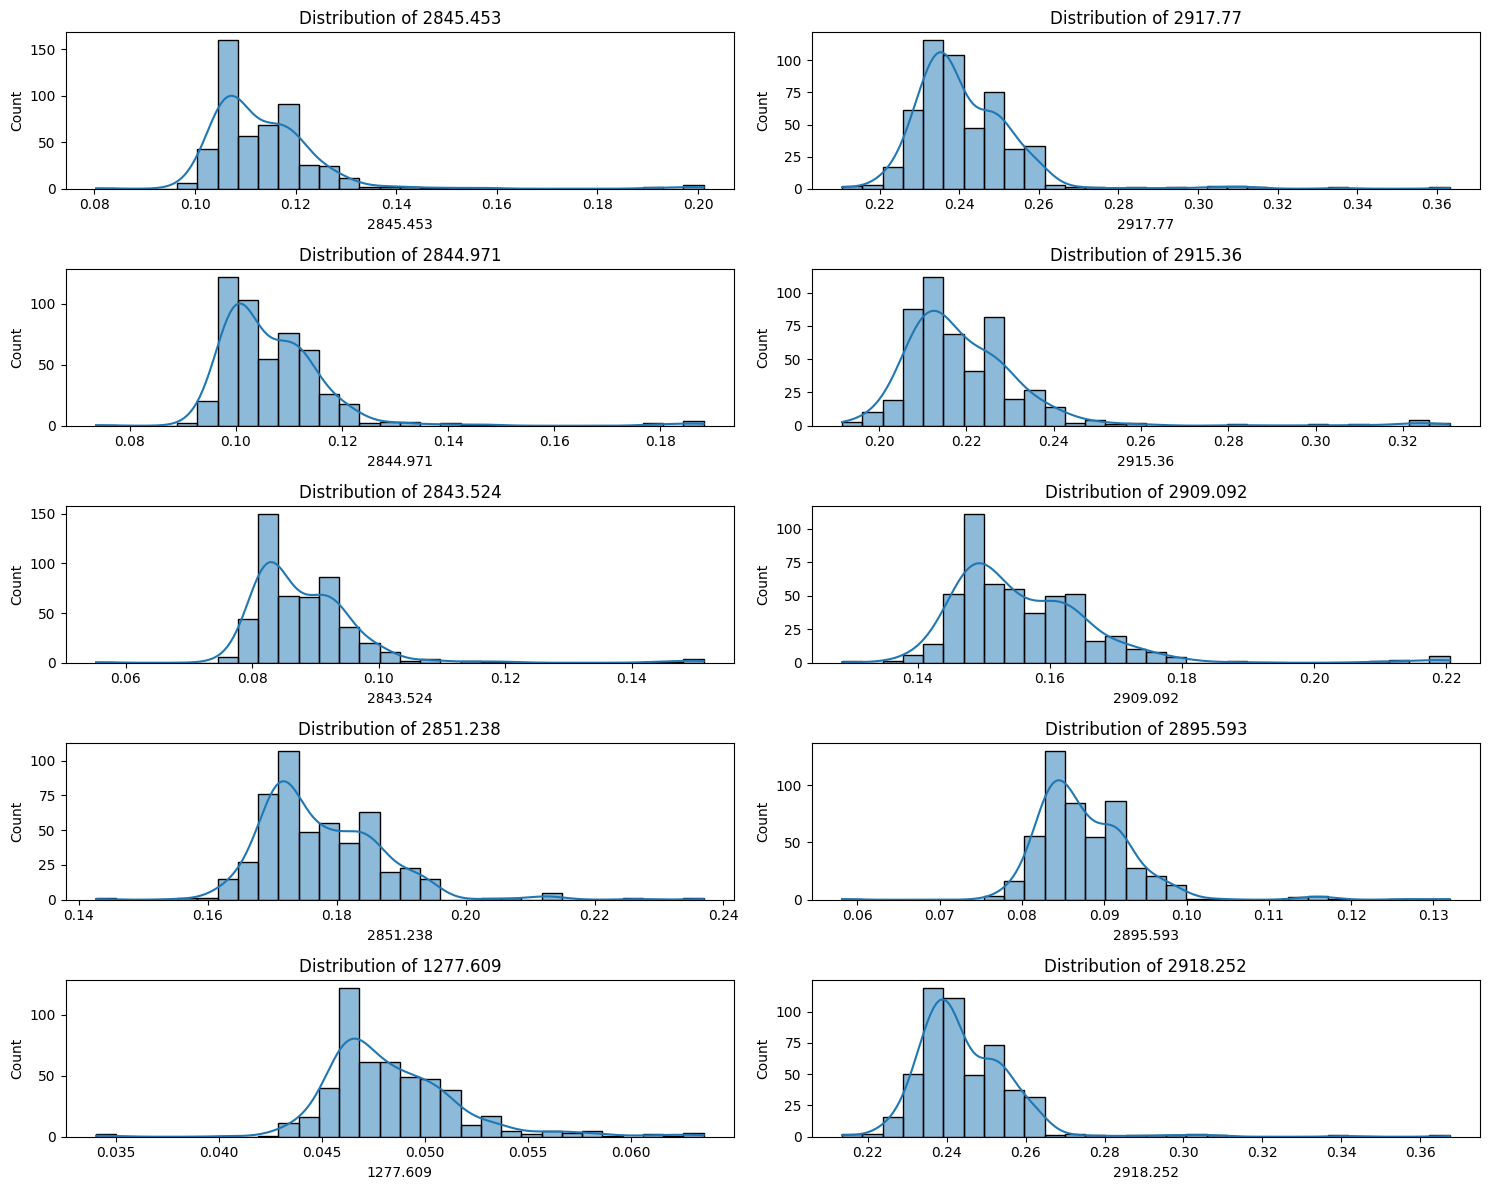

In [8]:
# Plot the distribution of the top 10 most important features
plt.figure(figsize=(15, 12))
for i, idx in enumerate(indices):
    plt.subplot(5, 2, i + 1)
    sns.histplot(df_0[numeric_cols_df_0[idx]], bins=30, kde=True)
    plt.title(f'Distribution of {numeric_cols_df_0[idx]}')
plt.tight_layout()
plt.show()

In [9]:
from scipy import stats

# Define a function to remove outliers using Z-score
def remove_outliers_zscore(df, columns, threshold=3):
    z_scores = np.abs(stats.zscore(df[columns]))
    return df[(z_scores < threshold).all(axis=1)]

# Remove outliers from the top 10 important features
top_features = [numeric_cols_df_0[idx] for idx in indices]
df_0_cleaned = remove_outliers_zscore(df_0, top_features)

# Check the shape of the cleaned dataframe
print("Original Data Shape:", df_0.shape)
print("Cleaned Data Shape:", df_0_cleaned.shape)


Original Data Shape: (503, 6958)
Cleaned Data Shape: (492, 6958)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Split the cleaned data into train and test sets
X_cleaned = df_0_cleaned[numeric_cols_df_0]
y_cleaned = df_0_cleaned[target]

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.5, random_state=42)

# Train the RandomForest model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Analyze accuracy per 'prov_char'
df_0_test_cleaned = df_0_cleaned.loc[X_test.index]
df_0_test_cleaned['predicted'] = y_pred
df_0_test_cleaned['actual'] = y_test.values

prov_char_analysis = df_0_test_cleaned.groupby('prov_char').apply(lambda x: (x['actual'] == x['predicted']).mean())
print(prov_char_analysis)


Classification Report:
               precision    recall  f1-score   support

    Non-Thai       0.95      0.70      0.81        80
        Thai       0.87      0.98      0.92       166

    accuracy                           0.89       246
   macro avg       0.91      0.84      0.86       246
weighted avg       0.90      0.89      0.89       246

Confusion Matrix:
 [[ 56  24]
 [  3 163]]
prov_char
BBX    0.454545
CBI    1.000000
CCO    1.000000
CPN    1.000000
JHR    1.000000
KBI    1.000000
KBX    0.181818
KRI    1.000000
KTX    0.913043
NRT    1.000000
NWT    1.000000
PKN    0.875000
PLG    1.000000
PNA    1.000000
PTN    1.000000
RIX    0.777778
RNG    1.000000
SGR    1.000000
SKM    1.000000
SNI    0.967742
SNK    1.000000
SSX    1.000000
STN    1.000000
SUX    0.666667
TRG    0.950000
dtype: float64


C:\Users\pingk\AppData\Local\Temp\ipykernel_20784\4156967957.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prov_char_analysis = df_0_test_cleaned.groupby('prov_char').apply(lambda x: (x['actual'] == x['predicted']).mean())


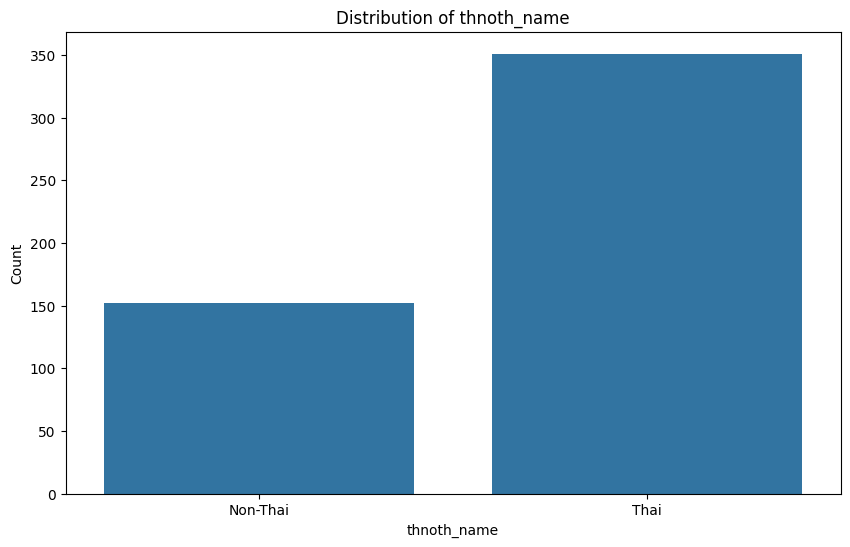

In [11]:
# Create a distribution plot for 'thnoth_name'
plt.figure(figsize=(10, 6))
sns.countplot(data=df_0, x=target)
plt.title('Distribution of thnoth_name')
plt.xlabel('thnoth_name')
plt.ylabel('Count')
plt.show()

In [12]:
# Verify the new distribution
print("New distribution of thnoth_name:")
print(df_0_cleaned[target].value_counts())

New distribution of thnoth_name:
thnoth_name
Thai        350
Non-Thai    142
Name: count, dtype: int64


In [13]:
# Separate Thai and Non-Thai samples
df_0_cleaned_thai = df_0_cleaned[df_0_cleaned[target] == 'Thai']
df_0_cleaned_non_thai = df_0_cleaned[df_0_cleaned[target] == 'Non-Thai']

In [14]:
from sklearn.ensemble import IsolationForest

# Identify and remove outliers in Thai samples using Isolation Forest
iso = IsolationForest(contamination=0.1, random_state=42)
yhat = iso.fit_predict(df_0_cleaned_thai[numeric_cols_df_0])
mask = yhat != -1
df_0_cleaned_thai_cleaned = df_0_cleaned_thai[mask]

In [15]:
# Combine the cleaned Thai samples with Non-Thai samples

df_1_cleaned = pd.concat([df_0_cleaned_thai_cleaned, df_0_cleaned_non_thai], axis=0).reset_index(drop=True)

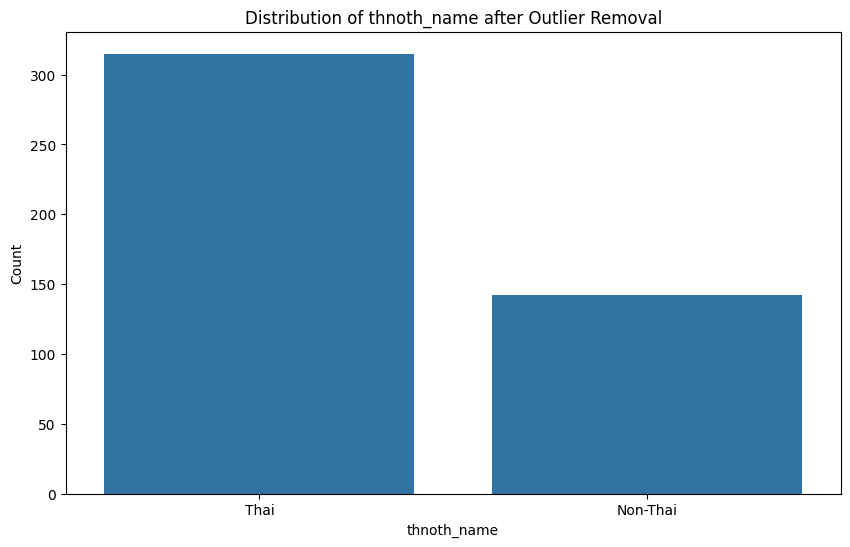

In [16]:
# Plot the distribution of thnoth_name after outlier removal
plt.figure(figsize=(10, 6))
sns.countplot(data=df_1_cleaned, x=target)
plt.title('Distribution of thnoth_name after Outlier Removal')
plt.xlabel('thnoth_name')
plt.ylabel('Count')
plt.show()


In [17]:
df_1_cleaned.to_csv(r"C:\Users\pingk\Downloads\fadhli nitip\asik_rt4NWIN_only CLND.csv", index=False)

In [18]:
# Verify the new distribution
print("New distribution of thnoth_name:")
print(df_1_cleaned[target].value_counts())

New distribution of thnoth_name:
thnoth_name
Thai        315
Non-Thai    142
Name: count, dtype: int64


In [19]:
# df_2 = df_1_cleaned.copy()

In [20]:
# from sklearn.preprocessing import LabelEncoder

# # Encoding the 'thnoth_name' column
# le = LabelEncoder()
# df_2['thnoth_name_encoded'] = le.fit_transform(df_2['thnoth_name'])

In [21]:
# # Define the target variable and numeric columns
# numeric_cols_df_2 = df_2.select_dtypes(include=[np.number]).columns.tolist()
# string_cols_df_2 = df_2.select_dtypes(exclude=[np.number]).columns.tolist()

# # Drop non-numeric columns and target column from numeric columns list
# numeric_cols_df_2 = [col for col in numeric_cols_df_2 if col not in string_cols_df_2]

In [22]:
# # Train a RandomForest model to get feature importances
# X_df_2 = df_2[numeric_cols_df_2].drop(columns=['thnoth_name_encoded'])
# y_df_2 = df_2['thnoth_name_encoded'].values

In [23]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score
# from imblearn.under_sampling import RandomUnderSampler

# # Initial model training to find consistent samples
# rf = RandomForestClassifier(random_state=42)
# rf.fit(X_df_2, y_df_2)

# # Get predictions
# df_2['predictions'] = rf.predict(X_df_2)

# # Keep samples that are correctly classified
# consistent_samples = df_2[df_2['thnoth_name_encoded'] == df_2['predictions']]

# # Separate features and target again with consistent samples
# X_df_2_consistent = consistent_samples.drop(columns=['thnoth_name', 'thnoth_name_encoded', 'predictions'])
# y_df_2_consistent = consistent_samples['thnoth_name_encoded'].values

# # Ensure X_df_2_consistent contains only numeric columns
# X_df_2_consistent = X_df_2_consistent.select_dtypes(include=[np.number])

# # Map for original string labels to numeric encoded labels
# label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# # Step 8: Apply undersampling to achieve a balanced dataset
# rus = RandomUnderSampler(sampling_strategy={label_mapping['Thai']: 152, label_mapping['Non-Thai']: 152}, random_state=42)
# X_df_2_balanced, y_df_2_balanced = rus.fit_resample(X_df_2_consistent, y_df_2_consistent)

# # Step 9: Display the new distribution of 'thnoth_name'
# balanced_df = consistent_samples.iloc[rus.sample_indices_]
# thnoth_name_distribution = balanced_df['thnoth_name'].value_counts()
# print(thnoth_name_distribution)


In [24]:
# # Check the distribution of 'thnoth_name' after undersampling

# import matplotlib.pyplot as plt
# import seaborn as sns

# # Plot the distribution of 'thnoth_name'
# plt.figure(figsize=(10, 6))
# sns.countplot(data=balanced_df, x='thnoth_name')
# plt.title('Distribution of thnoth_name after Undersampling')
# plt.xlabel('thnoth_name')
# plt.ylabel('Count')
# plt.show()


In [25]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, confusion_matrix
# from sklearn.model_selection import LeaveOneGroupOut
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Initialize and encode the 'prov_char' column
# le_prov = LabelEncoder()
# prov_char_encoded = le_prov.fit_transform(balanced_df['prov_char'])

# # Define features and target for the balanced dataset
# X_balanced = balanced_df.drop(columns=['thnoth_name', 'thnoth_name_encoded'])
# y_balanced = balanced_df['thnoth_name_encoded'].values

# # Ensure X_balanced contains only numeric columns
# X_balanced = X_balanced.select_dtypes(include=[np.number])

# # Initialize LOGO-CV
# logo = LeaveOneGroupOut()

# # Arrays to store results
# accuracies = []
# left_out_groups = []
# all_y_test = []
# all_y_pred = []

# # Perform LOGO-CV
# for train_idx, test_idx in logo.split(X_balanced, y_balanced, groups=prov_char_encoded):
#     X_train, X_test = X_balanced.iloc[train_idx], X_balanced.iloc[test_idx]
#     y_train, y_test = y_balanced[train_idx], y_balanced[test_idx]
    
#     # Train the model
#     rf.fit(X_train, y_train)
    
#     # Predict and evaluate
#     y_pred = rf.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
    
#     # Store results
#     accuracies.append(accuracy)
#     left_out_groups.append(balanced_df['prov_char'].iloc[test_idx].unique())
#     all_y_test.extend(y_test)
#     all_y_pred.extend(y_pred)

# # Calculate mean accuracy
# mean_accuracy = np.mean(accuracies)
# print(f'Mean Accuracy: {mean_accuracy}')

# # Display left out groups and their accuracies
# for group, acc in zip(left_out_groups, accuracies):
#     print(f'Left out group: {group}, Accuracy: {acc}')

# # Generate confusion matrix
# conf_matrix = confusion_matrix(all_y_test, all_y_pred)
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()


In [26]:
# balanced_df.reset_index(drop=True, inplace=True)
# balanced_df

In [27]:
#balanced_df.to_csv(r"C:\Users\pingk\Downloads\fadhli nitip\asik_rt4_NWIN_CLND_BLNCD_2.csv", index=False)

the BEST
don't mess it up